# is the CUC cutoff we chose for CIOPS appropriate for LiveOcean?

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
import matplotlib.colors as colors
import gsw
import math

In [2]:
tracers = pd.read_csv('./OSM/tracers.csv')
tracers.head()

,Unnamed: 0,salt,temperature,transport,depth,season,year,section
0,3,30.715387,9.134833,0.002187,18.089465,summer,2017.0,loop
1,51,27.029570,10.487689,0.002511,2.196340,summer,2017.0,loop
2,101,29.024899,9.943184,0.002381,5.138868,summer,2017.0,loop
3,2690,29.043703,9.957072,0.002384,5.637972,summer,2017.0,loop
4,2790,28.461721,10.375201,0.002484,17.259097,summer,2017.0,loop


In [3]:
# now trim the dataframe such that its only for the southern cross section
d = tracers[(tracers.section == 'cuc') | (tracers.section == 'south') | (tracers.section == 'columbia')]
d=d.reset_index()
d

,index,Unnamed: 0,salt,temperature,transport,depth,season,year,section
0,7,3702,33.550346,7.565769,0.001812,160.108390,summer,2017.0,south
1,8,3706,32.892006,9.140887,0.002189,80.433257,summer,2017.0,south
2,9,3708,33.116806,8.571011,0.002052,87.417065,summer,2017.0,south
3,10,3710,33.774128,7.026506,0.001683,235.035305,summer,2017.0,south
4,11,3712,33.288593,8.324139,0.001993,121.370248,summer,2017.0,south
...,...,...,...,...,...,...,...,...,...
2366887,5521738,27783845,33.699165,6.822478,0.001247,174.665842,summer,2021.0,south
2366888,5521739,27783846,33.747108,6.651074,0.001215,209.400240,summer,2021.0,south
2366889,5521743,27783850,33.931908,6.013258,0.001099,300.929977,summer,2021.0,cuc
2366890,5521746,27783853,33.709015,6.644220,0.001214,203.245262,summer,2021.0,south


In [4]:
# I want to add lines of constant density to see if there's a correlation between the water masses we see and density
bins = [np.linspace(21, 36,100),np.linspace(3, 16,100)]
SA, t = np.meshgrid(bins[0],bins[1])
# don't acutally want the density to be pressure denpendent for this purpose so make artificial P
p = np.array([50 for i in range(np.shape(SA)[0]*np.shape(SA)[1])])
p = p.reshape(100,100)

CT = np.zeros(np.shape(p))
rho = np.zeros(np.shape(p))
spice = np.zeros(np.shape(p))

for i in range(np.shape(p)[0]): 
    CT[i,:] = gsw.CT_from_t(SA[i,:],t[i,:],p[i,:])
    rho[i,:] = gsw.rho_alpha_beta(SA[i,:], CT[i,:], p[i,:])[0]
    spice[i,:] = gsw.spiciness0(SA[i,:], CT[i,:])

In [5]:
def fmt(x):
    x-=1000
    s = f"{x:.0f}"
    return rf"{s}"

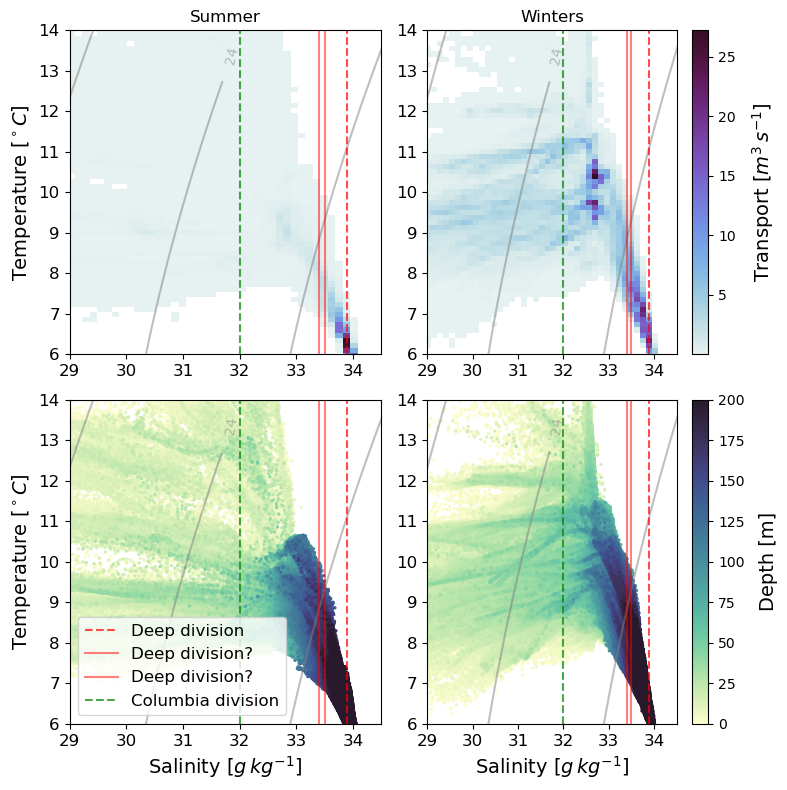

In [6]:
# south only
fig, ax = plt.subplots(2,2, figsize=(8,8))

# first summer, coloured by transport
bins = [np.linspace(22,35,100),np.linspace(3,15.5,100)]

H, xedges, yedges=np.histogram2d(d.salt[d.season=='summer'],d.temperature[d.season=='summer'],weights=d.transport[d.season=='summer'],bins=bins)
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0,0].pcolormesh(X, Y, H_final, cmap=cmap)#, norm=colors.LogNorm(vmin=10, vmax=100))
ax[0,0].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
# cb = fig.colorbar(im, ax=ax[0])
# cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)

# and coloured by depth
cmap = cm.cm.deep
idx = d.depth[d.season=='summer'].argsort()
salt, temp, depth = np.array(d.salt[d.season=='summer'])[idx], np.array(d.temperature[d.season=='summer'])[idx], np.array(d.depth[d.season=='summer'])[idx]
sc=ax[1,0].scatter(salt,temp,c=depth, cmap=cmap,s=2, vmin=0, vmax=200)
ax[1,0].set_ylabel('Temperature [$^\circ C$]', fontsize=14)
ax[1,0].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)

# next winter, coloured by transport
H, xedges, yedges=np.histogram2d(d.salt[d.season=='winter'],d.temperature[d.season=='winter'],weights=d.transport[d.season=='winter'],bins=bins)
H = H.T
H_final = np.where(H>0, H, H*np.nan)
cmap = cm.cm.dense
cmap.set_bad('white')
X, Y = np.meshgrid(xedges, yedges)
im = ax[0,1].pcolormesh(X, Y, H_final, cmap=cmap)#, norm=colors.LogNorm(vmin=10, vmax=100))
cb = fig.colorbar(im, ax=ax[0,1])
cb.set_label('Transport [$m^{3}\,s^{-1}$]', labelpad=10, fontsize=14)

# and coloured by depth
cmap = cm.cm.deep
idx = d.depth[d.season=='winter'].argsort()
salt, temp, depth = np.array(d.salt[d.season=='winter'])[idx], np.array(d.temperature[d.season=='winter'])[idx], np.array(d.depth[d.season=='winter'])[idx]
sc=ax[1,1].scatter(salt,temp,c=depth, cmap=cmap,s=2, vmin=0, vmax=200)
ax[1,1].set_xlabel('Salinity [$g\,kg^{-1}$]', fontsize=14)
cb = fig.colorbar(sc, ax=ax[1,1])
cb.set_label('Depth [m]', labelpad=10, fontsize=14)

ii=[0,0,1,1]
jj=[0,1,0,1]
for k in range(4):
    CS=ax[ii[k],jj[k]].contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax[ii[k],jj[k]].clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
    ax[ii[k],jj[k]].set_yticks(np.arange(6,17,1))
    ax[ii[k],jj[k]].set_yticklabels(np.arange(6,17,1),fontsize=12)
    ax[ii[k],jj[k]].set_xticks(np.arange(26,35,1))
    ax[ii[k],jj[k]].set_xticklabels(np.arange(26,35,1),fontsize=12)
    ax[ii[k],jj[k]].set_ylim([6, 14])
    ax[ii[k],jj[k]].set_xlim([29, 34.5])

    # division between water masses
    ax[ii[k],jj[k]].plot([33.9,33.9],[6,14],'r--', alpha=0.7, label='Deep division')
    ax[ii[k],jj[k]].plot([33.4,33.4],[6,14],'r', alpha=0.5, label='Deep division?')
    ax[ii[k],jj[k]].plot([33.5,33.5],[6,14],'r', alpha=0.5, label='Deep division?')
    
    
    # columbia delineation
    ax[ii[k],jj[k]].plot([32,32],[6,14],'g--',alpha=0.7,label='Columbia division')

ax[1,0].legend(loc='lower left', fontsize=12)
ax[0,0].set_title('Summer', fontsize=12)
ax[0,1].set_title('Winters', fontsize=12)
plt.tight_layout()

## Cross sections of the south

In [7]:
def round_to_2(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+1)

def round_to_3(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+2)

def FluxEW_ROMS(mydata, boolean,y, xmin, xmax, maxdepth, m2lon, ax):
    
    units = '$m^3 \, s^{-1} m^{-2}$'
    
    time = np.abs(np.max(mydata.init_t)-1440)

    cmap = cm.cm.speed
    cmap.set_under('white')
    
    depths = mydata.final_depth[boolean]
    transports = mydata.final_transp[boolean]/time
    lons = mydata.final_lon[boolean]
    
    t_min = 0.000000000001
    tick = 0.01
    t_max = (tick/np.sum(transports)).values/m2lon
        
    H, xedges, yedges, im = ax.hist2d(lons, depths, bins=[np.array(mymesh.lon_rho[y,xmin-1:xmax+1]), 
                                    np.arange(0,np.max(mymesh.h[y,xmin:xmax]),10)],weights= transports, 
                                    cmap=cm.cm.speed, vmin = t_min, vmax=t_max, density= True)
    
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, tick])
    cb1.set_label(units, labelpad=-20)
    
    distance = round_to_3(_distance_(mymesh.lat_rho[y,xmin],mymesh.lat_rho[y,xmax],mymesh.lon_rho[y,xmin],mymesh.lon_rho[y,xmax]))
    ax.set_xlabel(str(distance)[:-2]+" km")

    ax.fill_between(mymesh.lon_rho[y,xmin-1:xmax+1],mymesh.h[y,xmin-1:xmax+1], 500, color='lightgray')

    ax.invert_yaxis()
    ax.set_xticks([mymesh.lon_rho[y,xmin+2], mymesh.lon_rho[y,xmax-2]])
    ax.set_xticklabels(np.round([mymesh.lon_rho[y,xmin+2], mymesh.lon_rho[y,xmax-2]],2))
    ax.set_xlim((mymesh.lon_rho[y,xmin], mymesh.lon_rho[y,xmax]))
    ax.set_ylim((maxdepth, 0))
    full_title = str(round_to_2(np.sum(transports).values))[:-2]+" "+units
    ax.set_title(str(full_title))
    mydata.close()

def _distance_(lat1,lat2,lon1,lon2):
    """
    Calculate the Haversine distance.
    Returns
    -------
    distance_in_km : float
    """
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [8]:
mymesh = xr.open_dataset('/data1/bbeutel/LO_output/grid/grid.nc')

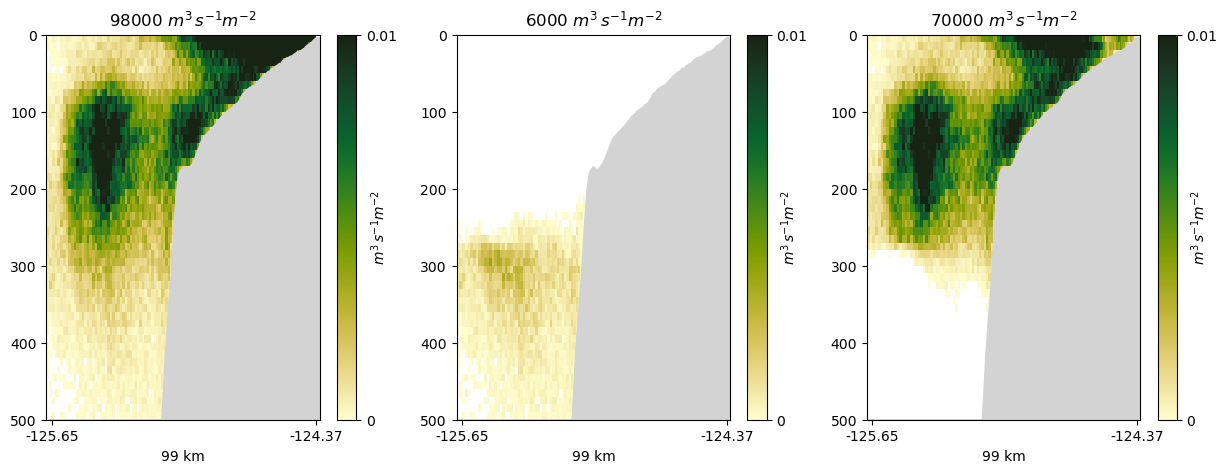

In [9]:
# cross sections of flow across the southern boundary
data = xr.open_dataset('./OSM/20180224/ariane_positions_quantitative.nc')
boolean = (data.final_section == 2) #for all south

y = 744
xmin=192
xmax=317

m2lon=1.6691435255493834*(10**-5) #figure out what this should actually be in ROMS

figure, ax = plt.subplots(1,3,figsize=(15,5))
FluxEW_ROMS(data, boolean, y, xmin, xmax, 500, m2lon, ax[0])

#try cuc delineation
boolean = (data.final_section == 2) & (data.final_salt >= 33.9)
FluxEW_ROMS(data, boolean, y, xmin, xmax, 500, m2lon, ax[1])

#and south delineation
boolean = (data.final_section == 2) & (data.final_salt < 33.9) & (data.final_salt > 32)
FluxEW_ROMS(data, boolean, y, xmin, xmax, 500, m2lon, ax[2])

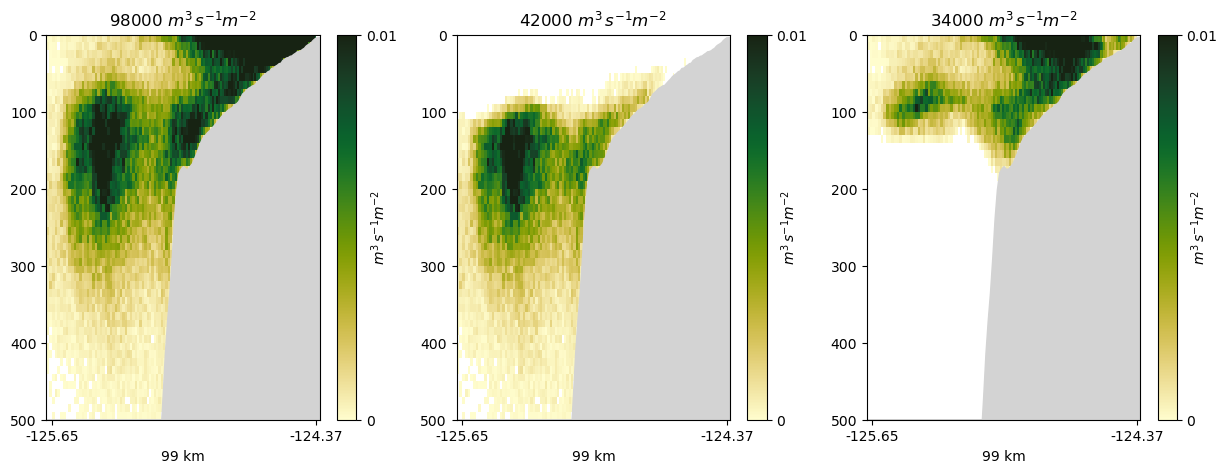

In [10]:
# ok clearly that delineation did not work

# cross sections of flow across the southern boundary
data = xr.open_dataset('./OSM/20180224/ariane_positions_quantitative.nc')
boolean = (data.final_section == 2) #for all south

y = 744
xmin=192
xmax=317

m2lon=1.6691435255493834*(10**-5) #figure out what this should actually be in ROMS

figure, ax = plt.subplots(1,3,figsize=(15,5))
FluxEW_ROMS(data, boolean, y, xmin, xmax, 500, m2lon, ax[0])

high = 33.4
low = 32
#try cuc delineation
boolean = (data.final_section == 2) & (data.final_salt >= high)
FluxEW_ROMS(data, boolean, y, xmin, xmax, 500, m2lon, ax[1])

#and south delineation
boolean = (data.final_section == 2) & (data.final_salt < high) & (data.final_salt > low)
FluxEW_ROMS(data, boolean, y, xmin, xmax, 500, m2lon, ax[2])

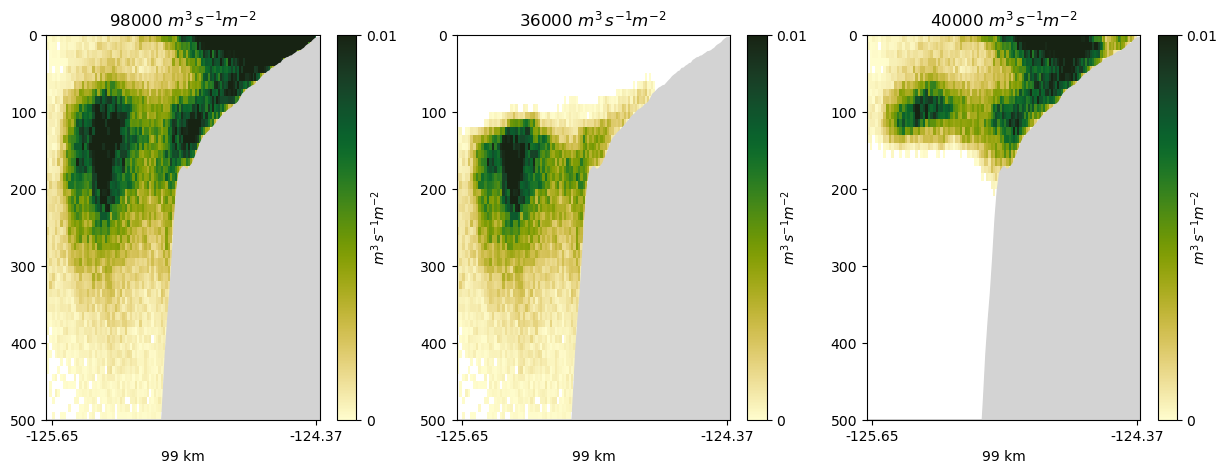

In [11]:
# ok clearly that delineation did not work

# cross sections of flow across the southern boundary
data = xr.open_dataset('./OSM/20180224/ariane_positions_quantitative.nc')
boolean = (data.final_section == 2) #for all south

y = 744
xmin=192
xmax=317

m2lon=1.6691435255493834*(10**-5) #figure out what this should actually be in ROMS

figure, ax = plt.subplots(1,3,figsize=(15,5))
FluxEW_ROMS(data, boolean, y, xmin, xmax, 500, m2lon, ax[0])

high = 33.5
low = 32
#try cuc delineation
boolean = (data.final_section == 2) & (data.final_salt >= high)
FluxEW_ROMS(data, boolean, y, xmin, xmax, 500, m2lon, ax[1])

#and south delineation
boolean = (data.final_section == 2) & (data.final_salt < high) & (data.final_salt > low)
FluxEW_ROMS(data, boolean, y, xmin, xmax, 500, m2lon, ax[2])

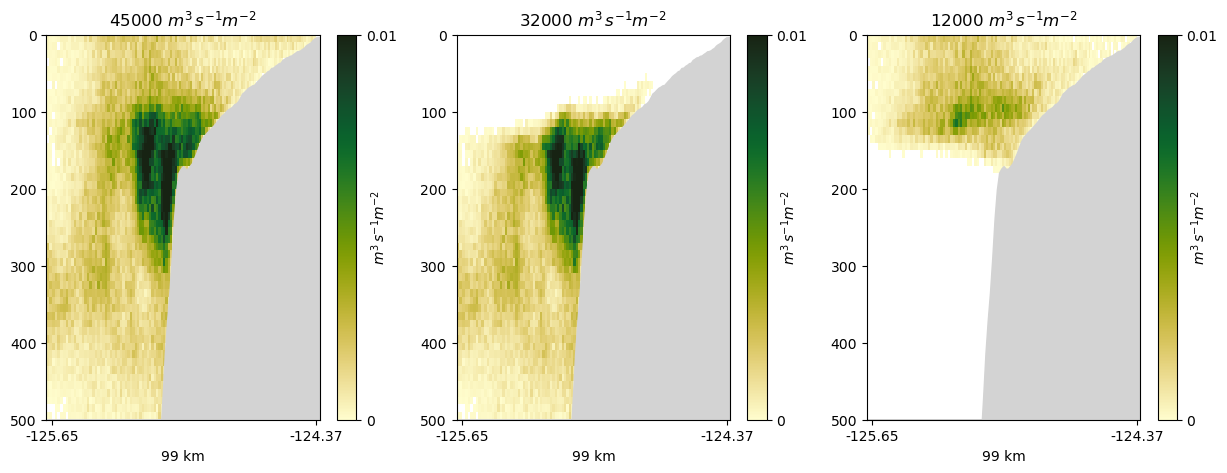

In [12]:
# lets try this same division over the different seasons

# summer 2017 (really just want CUC)
## cross sections of flow across the southern boundary
data = xr.open_dataset('./OSM/20171020/ariane_positions_quantitative.nc')
boolean = (data.final_section == 2) #for all south

y = 744
xmin=192
xmax=317

m2lon=1.6691435255493834*(10**-5) #figure out what this should actually be in ROMS

figure, ax = plt.subplots(1,3,figsize=(15,5))
FluxEW_ROMS(data, boolean, y, xmin, xmax, 500, m2lon, ax[0])
#try cuc delineation
boolean = (data.final_section == 2) & (data.final_salt >= high)
FluxEW_ROMS(data, boolean, y, xmin, xmax, 500, m2lon, ax[1])

#and south delineation
boolean = (data.final_section == 2) & (data.final_salt < high) & (data.final_salt > low)
FluxEW_ROMS(data, boolean, y, xmin, xmax, 500, m2lon, ax[2])